# 1 Layer RNN

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter

from torchinfo import summary

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from tqdm import tqdm

In [3]:
DATA_PATH = "../data/filtered_df.csv"
SAVED_MODELS_PATH = "saved_models/"
RUNS_PATH = "runs/"

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [5]:
class TemperatureDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(TemperatureDataset, self).__init__()

        self.X = torch.from_numpy(X).type(torch.FloatTensor).to(DEVICE)
        self.y = torch.from_numpy(y).type(torch.LongTensor).to(DEVICE)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].reshape(-1, 1), self.y[idx]

In [6]:
df = pd.read_csv(DATA_PATH, index_col=False)
df = df.sample(frac=1)
df.reset_index(drop=True, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1432,1433,1434,1435,1436,1437,1438,1439,disease,disease_encoded
0,0.608480,0.598834,0.561543,0.516197,0.493182,0.470632,0.451448,0.444694,0.440362,0.460799,...,-0.084885,-0.081870,-0.076004,-0.064141,-0.072773,-0.083555,-0.041876,-0.044620,non-infectious diseases,1
1,-0.596902,-0.585741,-0.594776,-0.634435,-0.645163,-0.657366,-0.667587,-0.652879,-0.648149,-0.622178,...,-0.312937,-0.305335,-0.294055,-0.278893,-0.284884,-0.286651,-0.235470,-0.234111,dengue,0
2,0.188478,0.175019,0.136987,0.082889,0.053742,0.024502,-0.001751,-0.010226,-0.021122,-0.008587,...,-0.143789,-0.134832,-0.122985,-0.105733,-0.109182,-0.113900,-0.066457,-0.064393,non-tubercular bacterial infection,2
3,0.519412,0.509976,0.473376,0.426905,0.403163,0.379625,0.359229,0.352203,0.346466,0.365075,...,-0.014313,0.007373,0.031979,0.064154,0.077049,0.083477,0.141285,0.159627,non-infectious diseases,1
4,0.767512,0.739527,0.758782,0.697397,0.656853,0.564494,0.540059,0.513788,0.503806,0.518631,...,0.544003,0.534859,0.525977,0.528615,0.512232,0.475777,-1.308434,-1.308317,dengue,0


In [7]:
X = df.drop("disease", axis=1)
X = X.drop("disease_encoded", axis=1)
y = df["disease_encoded"]

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()
train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()

In [9]:
train_dataset = TemperatureDataset(train_data, train_labels)
test_dataset = TemperatureDataset(test_data, test_labels)

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [11]:
INPUT_SIZE = 1
HIDDEN_SIZE = 64
OUTPUT_SIZE = 4
NUM_LAYERS = 1
SEQ_LENGTH = 1440

In [12]:
class Model(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE, num_layers=NUM_LAYERS):
        super(Model, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = x.to(DEVICE)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)

        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return self.softmax(out)

In [13]:
sample_x, sample_y = next(iter(train_loader))
sample_x.shape

torch.Size([8, 1440, 1])

## SGD

In [14]:
model = Model()
model = model.to(DEVICE)
model

Model(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [15]:
summary(model, input_data=sample_x)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 4]                    --
├─RNN: 1-1                               [8, 1440, 64]             4,288
├─Linear: 1-2                            [8, 4]                    260
├─Softmax: 1-3                           [8, 4]                    --
Total params: 4,548
Trainable params: 4,548
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 49.40
Input size (MB): 0.05
Forward/backward pass size (MB): 5.90
Params size (MB): 0.02
Estimated Total Size (MB): 5.96

In [16]:
tb_board = RUNS_PATH + "rnn_1_layer_sgd"
writer = SummaryWriter(tb_board)

In [17]:
writer.add_graph(model, sample_x)

In [18]:
EPOCHS = 200

acc_list = []
f1_list = []
recall_list = []
precision_list = []

loss_list = []

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [20]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  labels_list = []
  preds_list = []

  for (x, y) in train_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)

    yhat = model(x)

    labels_list.extend(y.cpu())
    preds_list.extend(yhat.argmax(1).cpu())

    loss = loss_fn(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  loss_list.append(avg_loss)

  acc = accuracy_score(labels_list, preds_list)
  pre = precision_score(labels_list, preds_list, average='weighted', zero_division=0)
  rec = recall_score(labels_list, preds_list, average='weighted', zero_division=0)
  f1 = f1_score(labels_list, preds_list, average='weighted', zero_division=0)

  acc_list.append(acc)
  precision_list.append(pre)
  recall_list.append(rec)
  f1_list.append(f1)

  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", acc, epoch)
  writer.add_scalar("Train/Precision", pre, epoch)
  writer.add_scalar("Train/Recall", rec, epoch)
  writer.add_scalar("Train/F1", f1, epoch)

  print(f"Epoch: {epoch + 1} - Loss: {avg_loss} - Accuracy: {acc} - Precision: {pre} - Recall: {rec} - F1: {f1}")

Epoch: 1 - Loss: 1.3875259399414062 - Accuracy: 0.2 - Precision: 0.10624040920716113 - Recall: 0.2 - F1: 0.12503656428666401
Epoch: 2 - Loss: 1.3862123092015584 - Accuracy: 0.20869565217391303 - Precision: 0.11196961760083814 - Recall: 0.20869565217391303 - F1: 0.13304910449160753
Epoch: 3 - Loss: 1.3871660153071086 - Accuracy: 0.20869565217391303 - Precision: 0.10732919254658385 - Recall: 0.20869565217391303 - F1: 0.13173322840842022
Epoch: 4 - Loss: 1.386795171101888 - Accuracy: 0.20869565217391303 - Precision: 0.10279880302763597 - Recall: 0.20869565217391303 - F1: 0.13055072463768114
Epoch: 5 - Loss: 1.3869433720906577 - Accuracy: 0.21739130434782608 - Precision: 0.10643747893495113 - Recall: 0.21739130434782608 - F1: 0.13752860411899312
Epoch: 6 - Loss: 1.3861531178156534 - Accuracy: 0.23478260869565218 - Precision: 0.11703010033444816 - Recall: 0.23478260869565218 - F1: 0.15332222882737595
Epoch: 7 - Loss: 1.3859685897827148 - Accuracy: 0.25217391304347825 - Precision: 0.12571473

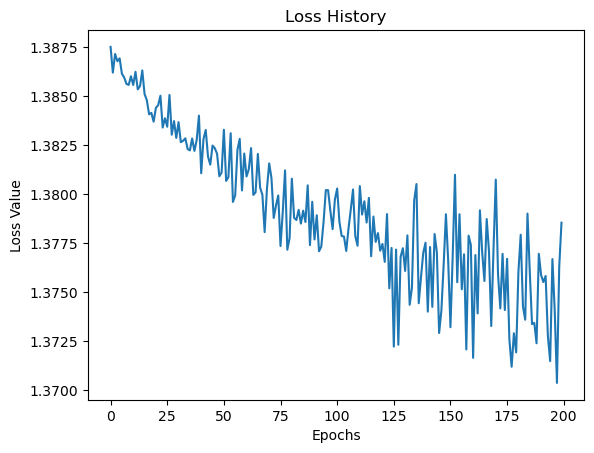

In [21]:
plt.title("Loss History")
plt.plot(range(EPOCHS), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.savefig("figures/training_loss_history_1_layer_rnn_sgd.pdf", bbox_inches="tight")
plt.show()

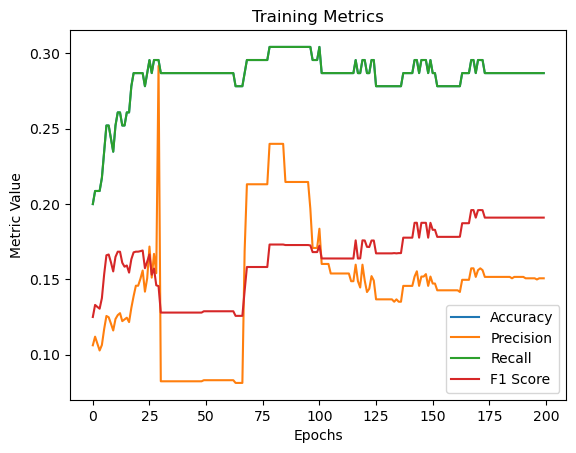

In [22]:
plt.title("Training Metrics")
plt.plot(range(EPOCHS), acc_list, label="Accuracy")
plt.plot(range(EPOCHS), precision_list, label="Precision")
plt.plot(range(EPOCHS), recall_list, label="Recall")
plt.plot(range(EPOCHS), f1_list, label="F1 Score")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.savefig("figures/training_metrics_1_layer_rnn.pdf", bbox_inches="tight")
plt.show()

In [23]:
print(f"Mean Training Accuracy: {np.array(acc_list).mean()}")
print(f"Mean Training Precision: {np.array(precision_list).mean()}")
print(f"Mean Training Recall: {np.array(recall_list).mean()}")
print(f"Mean Training F1 Score: {np.array(f1_list).mean()}")

writer.add_scalar("Train/Mean Accuracy", np.array(acc_list).mean(), 0)
writer.add_scalar("Train/Mean Precision", np.array(precision_list).mean(), 0)
writer.add_scalar("Train/Mean Recall", np.array(recall_list).mean(), 0)
writer.add_scalar("Train/Mean F1 Score", np.array(f1_list).mean(), 0)

Mean Training Accuracy: 0.2847826086956522
Mean Training Precision: 0.14560433735568082
Mean Training Recall: 0.2847826086956522
Mean Training F1 Score: 0.1645197009962442


In [24]:
loss = 0.0
accuracy = 0.0
precision = 0.0
recall = 0.0
f1 = 0.0

In [25]:
model.eval()
with torch.no_grad():
  x = torch.tensor(test_data).type(torch.FloatTensor)
  y = torch.tensor(test_labels).type(torch.LongTensor)

  num_samples, num_features = x.shape
  x = x.reshape(num_samples, num_features, 1)

  yhat = model(x)

  yhat = yhat.cpu()
  loss = loss_fn(yhat, y)

  yhat = yhat.argmax(1)
  accuracy = accuracy_score(yhat, y)
  precision = precision_score(yhat, y, average='weighted', zero_division=0)
  recall = recall_score(yhat, y, average='weighted', zero_division=0)
  f1 = f1_score(yhat, y, average='weighted', zero_division=0)

In [26]:
print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing F1 Score: {f1}")

writer.add_scalar("Test/Loss", loss, 0)
writer.add_scalar("Test/Accuracy", accuracy, 0)
writer.add_scalar("Test/Precision", precision, 0)
writer.add_scalar("Test/Recall", recall, 0)
writer.add_scalar("Test/F1 Score", f1, 0)

Testing Loss: 1.3385446071624756
Testing Accuracy: 0.4482758620689655
Testing Precision: 0.6354679802955665
Testing Recall: 0.4482758620689655
Testing F1 Score: 0.5241379310344827


## Adam

In [27]:
model = Model()
model = model.to(DEVICE)
model

Model(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [28]:
summary(model, input_data=sample_x)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 4]                    --
├─RNN: 1-1                               [8, 1440, 64]             4,288
├─Linear: 1-2                            [8, 4]                    260
├─Softmax: 1-3                           [8, 4]                    --
Total params: 4,548
Trainable params: 4,548
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 49.40
Input size (MB): 0.05
Forward/backward pass size (MB): 5.90
Params size (MB): 0.02
Estimated Total Size (MB): 5.96

In [29]:
tb_board = RUNS_PATH + "1_layer_rnn_adam"
writer = SummaryWriter(tb_board)

In [30]:
EPOCHS = 200

acc_list = []
f1_list = []
recall_list = []
precision_list = []

loss_list = []

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [32]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  labels_list = []
  preds_list = []

  for (x, y) in train_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)

    yhat = model(x)

    labels_list.extend(y.cpu())
    preds_list.extend(yhat.argmax(1).cpu())

    loss = loss_fn(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  loss_list.append(avg_loss)

  acc = accuracy_score(labels_list, preds_list)
  pre = precision_score(labels_list, preds_list, average='weighted', zero_division=0)
  rec = recall_score(labels_list, preds_list, average='weighted', zero_division=0)
  f1 = f1_score(labels_list, preds_list, average='weighted', zero_division=0)

  acc_list.append(acc)
  precision_list.append(pre)
  recall_list.append(rec)
  f1_list.append(f1)

  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", acc, epoch)
  writer.add_scalar("Train/Precision", pre, epoch)
  writer.add_scalar("Train/Recall", rec, epoch)
  writer.add_scalar("Train/F1", f1, epoch)

  print(f"Epoch: {epoch + 1} - Loss: {avg_loss} - Accuracy: {acc} - Precision: {pre} - Recall: {rec} - F1: {f1}")

Epoch: 1 - Loss: 1.3904856284459433 - Accuracy: 0.20869565217391303 - Precision: 0.04355387523629489 - Recall: 0.20869565217391303 - F1: 0.07206756334063184
Epoch: 2 - Loss: 1.3852848450342814 - Accuracy: 0.2782608695652174 - Precision: 0.18485109093804744 - Recall: 0.2782608695652174 - F1: 0.1838278131405761
Epoch: 3 - Loss: 1.382614008585612 - Accuracy: 0.30434782608695654 - Precision: 0.2146788990825688 - Recall: 0.30434782608695654 - F1: 0.17281077770973668
Epoch: 4 - Loss: 1.3823720773061117 - Accuracy: 0.2956521739130435 - Precision: 0.16298136645962732 - Recall: 0.2956521739130435 - F1: 0.16805293005671074
Epoch: 5 - Loss: 1.377154000600179 - Accuracy: 0.2782608695652174 - Precision: 0.14859184888964516 - Recall: 0.2782608695652174 - F1: 0.19157779600765654
Epoch: 6 - Loss: 1.379575824737549 - Accuracy: 0.30434782608695654 - Precision: 0.16583850931677016 - Recall: 0.30434782608695654 - F1: 0.21419922949917447
Epoch: 7 - Loss: 1.3798564513524374 - Accuracy: 0.33043478260869563 -

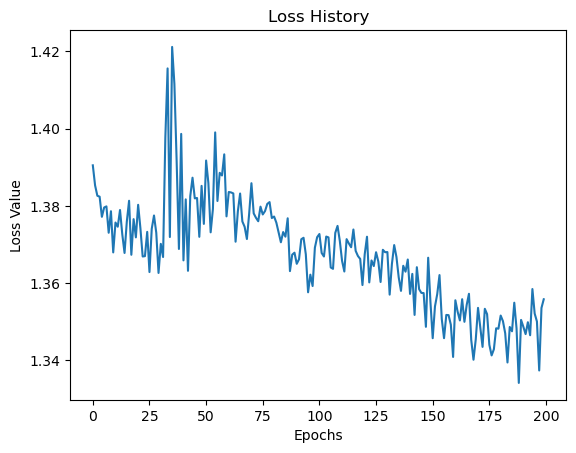

In [33]:
plt.title("Loss History")
plt.plot(range(EPOCHS), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.savefig("figures/training_loss_history_1_layer_rnn_adam.pdf", bbox_inches="tight")
plt.show()

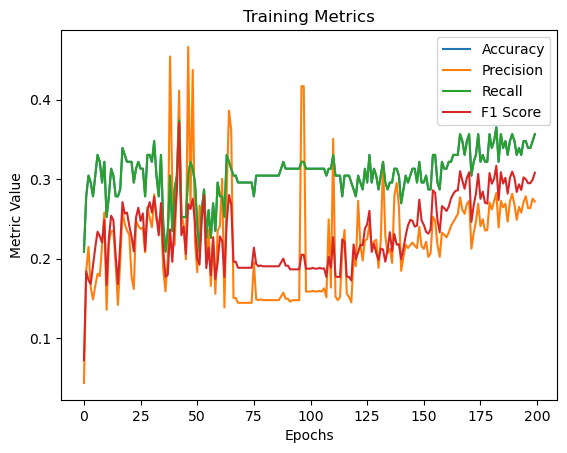

In [34]:
plt.title("Training Metrics")
plt.plot(range(EPOCHS), acc_list, label="Accuracy")
plt.plot(range(EPOCHS), precision_list, label="Precision")
plt.plot(range(EPOCHS), recall_list, label="Recall")
plt.plot(range(EPOCHS), f1_list, label="F1 Score")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.savefig("figures/training_metrics_1_layer_rnn_adam.pdf", bbox_inches="tight")
plt.show()

In [35]:
print(f"Mean Training Accuracy: {np.array(acc_list).mean()}")
print(f"Mean Training Precision: {np.array(precision_list).mean()}")
print(f"Mean Training Recall: {np.array(recall_list).mean()}")
print(f"Mean Training F1 Score: {np.array(f1_list).mean()}")

writer.add_scalar("Train/Mean Accuracy", np.array(acc_list).mean(), 0)
writer.add_scalar("Train/Mean Precision", np.array(precision_list).mean(), 0)
writer.add_scalar("Train/Mean Recall", np.array(recall_list).mean(), 0)
writer.add_scalar("Train/Mean F1 Score", np.array(f1_list).mean(), 0)

Mean Training Accuracy: 0.30634782608695654
Mean Training Precision: 0.2205714744388547
Mean Training Recall: 0.30634782608695654
Mean Training F1 Score: 0.2314526487616721


In [36]:
loss = 0.0
accuracy = 0.0
precision = 0.0
recall = 0.0
f1 = 0.0

In [37]:
model.eval()
with torch.no_grad():
  x = torch.tensor(test_data).type(torch.FloatTensor)
  y = torch.tensor(test_labels).type(torch.LongTensor)

  num_samples, num_features = x.shape
  x = x.reshape(num_samples, num_features, 1)

  yhat = model(x)

  yhat = yhat.cpu()
  loss = loss_fn(yhat, y)

  yhat = yhat.argmax(1)
  accuracy = accuracy_score(yhat, y)
  precision = precision_score(yhat, y, average='weighted', zero_division=0)
  recall = recall_score(yhat, y, average='weighted', zero_division=0)
  f1 = f1_score(yhat, y, average='weighted', zero_division=0)

In [38]:
print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing F1 Score: {f1}")

writer.add_scalar("Test/Loss", loss, 0)
writer.add_scalar("Test/Accuracy", accuracy, 0)
writer.add_scalar("Test/Precision", precision, 0)
writer.add_scalar("Test/Recall", recall, 0)
writer.add_scalar("Test/F1 Score", f1, 0)

Testing Loss: 1.3737051486968994
Testing Accuracy: 0.3103448275862069
Testing Precision: 0.3669950738916256
Testing Recall: 0.3103448275862069
Testing F1 Score: 0.33454570888997687
